# MLMAPPER USING NEURAL NETWORK

In [2]:
#import necessary libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split
from torch.utils.data import DataLoader,Dataset
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import r2_score
import cv2
import os

In [3]:
#getting the path to the folder 
dir=os.getcwd()

### DATA PATH

In [4]:
#paths to data 
albedo=dir+"/DATA/Data_Albedo/Albedo_Map.csv"
LPFe_Map=dir+"/DATA/Data_Albedo/LPFe_Map.csv"
LPK_Map=dir+"/DATA/Data_Albedo/LPK_Map.csv"
LPTh_Map=dir+"/DATA/Data_Albedo/LPTh_Map.csv"
LPTi_Map=dir+"/DATA/Data_Albedo/LPTi_Map.csv"

### DATA VISUALIZATION:

(359, 720)
(359, 360)


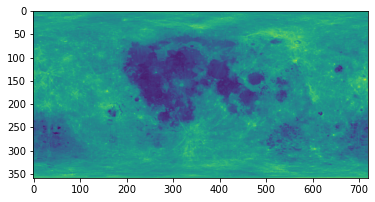

In [14]:
#lunar albedo map 
albedo_img=np.array(pd.read_csv(albedo))
print(np.shape(albedo_img))
a=albedo_img[:,360:720]
print(np.shape(a))
plt.imshow(albedo_img)
plt.show()

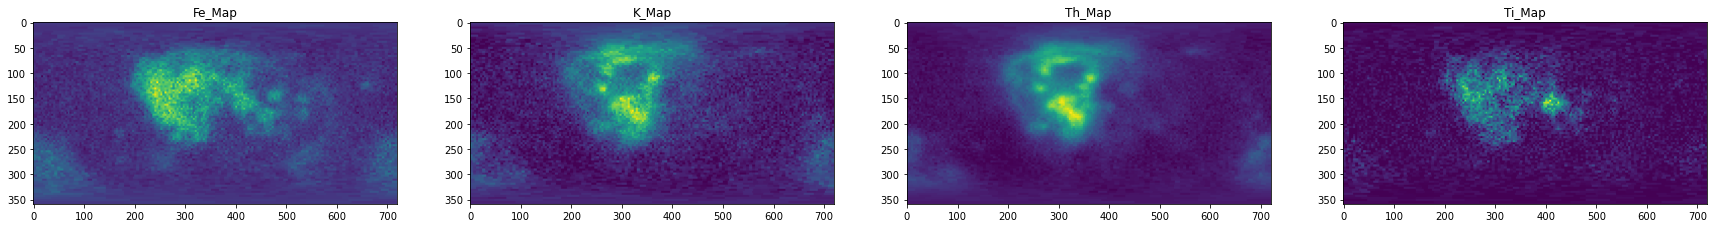

In [6]:
#chemical composition map of the moon surface
fe_map_img=np.array(pd.read_csv(LPFe_Map))
K_map_img=np.array(pd.read_csv(LPK_Map))
Th_map_img=np.array(pd.read_csv(LPTh_Map))
Ti_map_img=np.array(pd.read_csv(LPTi_Map))

ffig, faxes = plt.subplots(1,4 , figsize=(30,30))
faxes[0].imshow(fe_map_img)
faxes[0].set_title("Fe_Map")
faxes[0].grid(False)

faxes[1].imshow(K_map_img)
faxes[1].set_title("K_Map")
faxes[1].grid(False)

faxes[2].imshow(Th_map_img)
faxes[2].set_title("Th_Map")
faxes[2].grid(False)

faxes[3].imshow(Ti_map_img)
faxes[3].set_title("Ti_Map")
faxes[3].grid(False)


### CUSTOM DATASET TO GET INPUT,GT

In [7]:
#custom dataset for nearby pixels
class dataset_nearby_pixel(Dataset):
    def __init__(self,path_1,path_2,path_3,path_4,path_5,mode):
        self.path_1=path_1
        self.path_2=path_2
        self.path_3=path_3
        self.path_4=path_4
        self.path_5=path_5
        self.mode=mode
        #converting the data to ndarray
        self.X_1=np.array(pd.read_csv(path_1))
        self.X_2=np.array(pd.read_csv(path_2))
        self.X_3=np.array(pd.read_csv(path_3))
        self.X_4=np.array(pd.read_csv(path_4))
        self.X_5=cv2.GaussianBlur(np.array(pd.read_csv(path_5)),ksize=(0,0),sigmaX=9)
        self.X=[]
        self.Y=[]
        n,m=np.shape(self.X_5)[0],np.shape(self.X_5)[1]
        for i in range(1,n-1):
            for j in range(1,m-1):
                nearby=[]
                for chem in [self.X_1,self.X_2,self.X_3,self.X_4]:
                    for a in [-1,0,1]:
                        for b in [-1,0,1]:
                            nearby.append(chem[i+a][j+b])
                self.X.append(nearby)
                self.Y.append([self.X_5[i][j]])
        l=len(self.Y)//2
        if mode == "Train" or "train":
            self.X=np.array(self.X)[:l]
            self.Y=np.array(self.Y)[:l]
        elif mode== "Test" or "test":
            self.X=np.array(self.X)[l:]
            self.Y=np.array(self.Y)[l:]
    def __len__(self):
        self.filelength=np.shape(self.Y)[0]
        return self.filelength

    def __getitem__(self,idx):
        return torch.from_numpy(self.X[idx]),torch.from_numpy(self.Y[idx])



In [8]:
#custom dataset
class dataset(Dataset):
  def __init__(self,path_1,path_2,path_3,path_4,path_5,start_split,end_split):
    self.path_1=path_1
    self.path_2=path_2
    self.path_3=path_3
    self.path_4=path_4
    self.path_5=path_5
    self.start_split=start_split
    self.end_split=end_split
    #converting the data to tensors
    self.X_1=torch.FloatTensor(np.array(pd.read_csv(path_1)))
    self.X_2=torch.FloatTensor(np.array(pd.read_csv(path_2)))
    self.X_3=torch.FloatTensor(np.array(pd.read_csv(path_3)))
    self.X_4=torch.FloatTensor(np.array(pd.read_csv(path_4)))
    self.X_5=torch.FloatTensor(cv2.GaussianBlur(np.array(pd.read_csv(path_5)),ksize=(0,0),sigmaX=9))
    #normalizing the data
    self.X_1=(self.X_1[:,self.start_split:self.end_split].flatten()-torch.mean(self.X_1[:,self.start_split:self.end_split].flatten()))/torch.std(self.X_1[:,self.start_split:self.end_split].flatten())
    self.X_2=(self.X_2[:,self.start_split:self.end_split].flatten()-torch.mean(self.X_2[:,self.start_split:self.end_split].flatten()))/torch.std(self.X_2[:,self.start_split:self.end_split].flatten())
    self.X_3=(self.X_3[:,self.start_split:self.end_split].flatten()-torch.mean(self.X_3[:,self.start_split:self.end_split].flatten()))/torch.std(self.X_3[:,self.start_split:self.end_split].flatten())
    self.X_4=(self.X_4[:,self.start_split:self.end_split].flatten()-torch.mean(self.X_4[:,self.start_split:self.end_split].flatten()))/torch.std(self.X_4[:,self.start_split:self.end_split].flatten())
    self.X_5=self.X_5[:,self.start_split:self.end_split].flatten()
    self.X=torch.stack((self.X_1,self.X_2,self.X_3,self.X_4),1)  
    self.Y=self.X_5
  
  def __len__(self):
    self.filelength=len(self.Y)
    return self.filelength

  def __getitem__(self,idx):
    return self.X[idx],self.Y[idx]

### NEURAL NETWORK MODEL

In [9]:
#neural network model
class model(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(model, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden)
        self.hidden2 = torch.nn.Linear(n_hidden,n_hidden)
        self.hidden3 = torch.nn.Linear(n_hidden,n_hidden)
        self.predict = torch.nn.Linear(n_hidden, n_output)   
        self.dropout = torch.nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = self.dropout(F.relu(self.hidden1(x)))
        x = self.dropout(F.relu(self.hidden2(x)))
        x = self.dropout(F.relu(self.hidden3(x)))
        x = self.predict(x)            
        return x


### Train Function:

In [10]:
class train():
    def __init__(self,batch_size,epochs,lr,train_val_split,scheduler,near):
        self.batch_size=batch_size
        self.scheduler=scheduler
        self.epochs=epochs
        self.lr=lr
        self.train_val_split=train_val_split
        self.near=near
        if self.near== True:
            self.data=dataset_nearby_pixel(LPFe_Map,LPK_Map,LPTh_Map,LPTi_Map,albedo,mode="train")
            self.train_data,self.val_data=random_split(self.data,[len(self.data)-int(self.train_val_split*len(self.data)),int(self.train_val_split*len(self.data))],generator=torch.Generator().manual_seed(42))
            self.train_loader=DataLoader(self.train_data,batch_size=self.batch_size,shuffle=True)
            self.val_loader=DataLoader(self.val_data,batch_size=self.batch_size,shuffle=True)
            self.net=model(n_feature=36, n_hidden=25, n_output=1)
        else:
            self.data=dataset(LPFe_Map,LPK_Map,LPTh_Map,LPTi_Map,albedo,0,360)
            self.train_data,self.val_data=random_split(self.data,[len(self.data)-int(self.train_val_split*len(self.data)),int(self.train_val_split*len(self.data))],generator=torch.Generator().manual_seed(42))
            self.train_loader=DataLoader(self.train_data,batch_size=self.batch_size,shuffle=True)
            self.val_loader=DataLoader(self.val_data,batch_size=self.batch_size,shuffle=True)
            self.net=model(n_feature=4, n_hidden=4, n_output=1)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=self.lr)
        if self.scheduler==True:
            self.sched=torch.optim.lr_scheduler.ExponentialLR(self.optimizer,gamma=0.7)
        self.loss_func = torch.nn.MSELoss() 
        self.writer = SummaryWriter()
        
    def trainer(self):
        self.net=self.net.train()
        self.net=self.net.cuda()
        for epoch in range(self.epochs):
            for input,gt in self.train_loader:
                input = input.cuda()
                gt = gt.cuda()
                gt=torch.reshape(gt,(len(gt),1))
                output = self.net(input.float())
                loss = self.loss_func(output, gt.float())
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            if self.scheduler == True:
                self.sched.step()
            print('Epoch : {},  train loss : {}'.format(epoch+1,loss.item()))
            with torch.no_grad():
                for input,gt in self.val_loader:
                    input=input.cuda()
                    gt= gt.cuda()
                    gt=torch.reshape(gt,(len(gt),1))
                    val_output = self.net(input.float())
                    val_loss = self.loss_func(val_output,gt.float())
            print('Epoch : {},  val_loss : {}'.format(epoch+1,val_loss.item()))
            self.writer.add_scalar("Loss/train", loss, epoch)
            self.writer.add_scalar("Loss/val", val_loss, epoch)
            if self.scheduler == True:
                self.writer.add_scalar("lr/epoch",self.lr,epoch)
        torch.save(self.net.state_dict(),f"albedo_{self.epochs}_{self.lr}_{self.batch_size}.pth")

#### Normal Training 

In [ ]:
train_best=train(batch_size=64,epochs=100,lr=0.0001,train_val_split=0.3,scheduler=False,near=False)
train_best.trainer()

#### Nearby Training

In [11]:
train_best_near=train(batch_size=64,epochs=100,lr=0.0001,train_val_split=0.3,scheduler=False,near=True)
train_best_near.trainer()

Epoch : 1,  train loss : 3.663121461868286
Epoch : 1,  val_loss : 6.235400199890137
Epoch : 2,  train loss : 0.7315381765365601
Epoch : 2,  val_loss : 3.8570151329040527
Epoch : 3,  train loss : 0.07767129689455032
Epoch : 3,  val_loss : 0.2592722773551941
Epoch : 4,  train loss : 0.10861585289239883
Epoch : 4,  val_loss : 0.11481534689664841
Epoch : 5,  train loss : 0.008385946974158287
Epoch : 5,  val_loss : 0.017458129674196243
Epoch : 6,  train loss : 0.005931203253567219
Epoch : 6,  val_loss : 0.003923547919839621
Epoch : 7,  train loss : 0.0025380842853337526
Epoch : 7,  val_loss : 0.0029416827019304037
Epoch : 8,  train loss : 0.004413996357470751
Epoch : 8,  val_loss : 0.0031808745115995407
Epoch : 9,  train loss : 0.012463897466659546
Epoch : 9,  val_loss : 0.003448056522756815
Epoch : 10,  train loss : 0.0019360400037840009
Epoch : 10,  val_loss : 0.0037086177617311478
Epoch : 11,  train loss : 0.0040307193994522095
Epoch : 11,  val_loss : 0.010060365311801434
Epoch : 12,  tr

#### Test Normal

RMSE Loss on right half : 0.021777820362415982
R2 score: 0.5114797708710908


(array([2.000e+00, 2.000e+00, 1.000e+01, 1.000e+01, 2.900e+01, 4.300e+01,
        3.500e+01, 4.800e+01, 4.600e+01, 5.700e+01, 4.800e+01, 5.400e+01,
        5.700e+01, 1.210e+02, 1.860e+02, 2.440e+02, 2.710e+02, 2.900e+02,
        2.630e+02, 4.110e+02, 5.460e+02, 5.570e+02, 7.260e+02, 9.420e+02,
        8.910e+02, 9.890e+02, 9.980e+02, 1.149e+03, 1.225e+03, 1.250e+03,
        1.473e+03, 1.504e+03, 1.778e+03, 1.920e+03, 2.229e+03, 2.405e+03,
        2.457e+03, 2.796e+03, 3.098e+03, 3.721e+03, 4.325e+03, 4.465e+03,
        4.448e+03, 4.288e+03, 4.335e+03, 4.571e+03, 4.670e+03, 4.658e+03,
        4.926e+03, 4.677e+03, 4.332e+03, 4.120e+03, 4.000e+03, 3.379e+03,
        2.950e+03, 2.824e+03, 2.741e+03, 2.811e+03, 2.588e+03, 2.343e+03,
        2.153e+03, 1.968e+03, 1.658e+03, 1.473e+03, 1.311e+03, 1.185e+03,
        1.220e+03, 1.055e+03, 8.720e+02, 7.700e+02, 6.860e+02, 4.770e+02,
        3.970e+02, 2.180e+02, 2.070e+02, 2.250e+02, 1.820e+02, 1.720e+02,
        1.230e+02, 9.100e+01, 1.050e+0

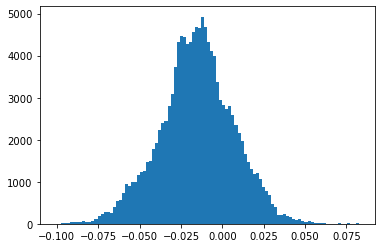

In [12]:
test_data=dataset(LPFe_Map,LPK_Map,LPTh_Map,LPTi_Map,albedo,360,720)
test_loader=DataLoader(test_data,batch_size=1)
loss_function=torch.nn.MSELoss()
net_test=model(4,4,1)
net_test=net_test.cuda()
net_test.load_state_dict(torch.load(dir+"/pytorch-models/albedo_blur_best.pth"))
right_predicted=[]
right_truth=[]
total_loss=[]
net_test=net_test.eval()
for i,l in test_loader:
    i=i.cuda()
    l=l.cuda()
    l=torch.reshape(l,(len(l),1))
    output=net_test(i.float())
    loss=loss_function(output,l.float())
    loss=loss.cpu().item()
    total_loss.append(np.sqrt(loss))
    right_predicted.append(output.cpu().item())
    right_truth.append(l.cpu().item())
    

print("RMSE Loss on right half :",np.mean(total_loss))
print("R2 score:",r2_score(right_truth,right_predicted))
residual=np.subtract(right_predicted,right_truth)
plt.hist(residual,bins=100)
plt.show()

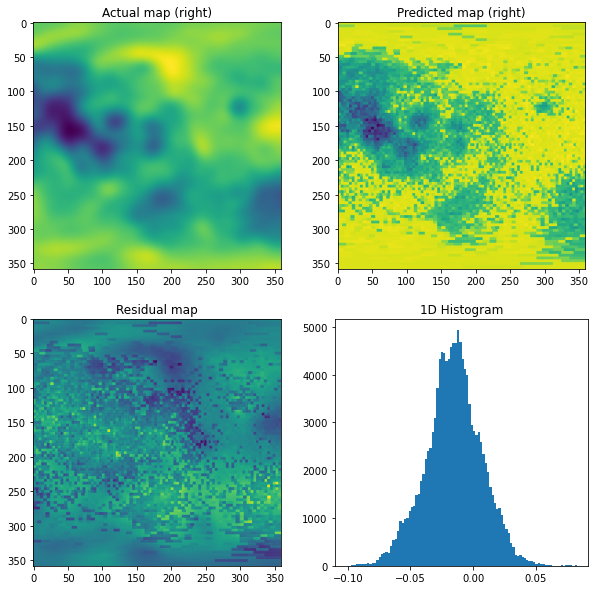

In [17]:
ffig, faxes = plt.subplots(2, 2, figsize=(10, 10))
faxes[0, 0].imshow(np.reshape(right_truth,(359,360)))
faxes[0, 0].set_title("Actual map (right)")
faxes[0, 0].grid(False)

faxes[0, 1].imshow(np.reshape(right_predicted,(359,360)))
faxes[0, 1].set_title("Predicted map (right)")
faxes[0, 1].grid(False)

faxes[1, 0].imshow(np.reshape(residual,(359,360)))
faxes[1, 0].set_title("Residual map")
faxes[1, 0].grid(False)

faxes[1, 1].hist(residual, bins=100)
faxes[1, 1].set_title("1D Histogram")
faxes[1, 1].grid(False)

#### Test Nearby


RMSE Loss on right half : 0.02398096107180612
R2 score: 0.6268074896858192


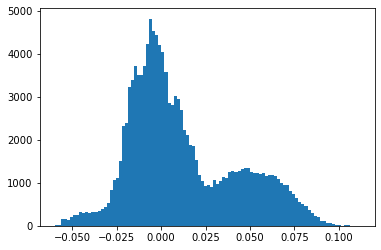

In [18]:
test_data_nearby=dataset_nearby_pixel(LPFe_Map,LPK_Map,LPTh_Map,LPTi_Map,albedo,mode="test")
test_loader_nearby=DataLoader(test_data_nearby,batch_size=1)
loss_function=torch.nn.MSELoss()
net_test=model(36,25,1)
net_test=net_test.cuda()
net_test.load_state_dict(torch.load(dir+"/pytorch-models/albedo_nearby_blur_best.pth"))
right_predicted_near=[]
right_truth_near=[]
total_loss_near=[]
net_test=net_test.eval()
for i,l in test_loader_nearby:
    i=i.cuda()
    l=l.cuda()
    l=torch.reshape(l,(len(l),1))
    output=net_test(i.float())
    loss=loss_function(output,l.float())
    loss=loss.cpu().item()
    total_loss_near.append(np.sqrt(loss))
    right_predicted_near.append(output.cpu().item())
    right_truth_near.append(l.cpu().item())
    

print("RMSE Loss on right half :",np.mean(total_loss_near))
print("R2 score:",r2_score(right_truth_near,right_predicted_near))
residual_near=np.subtract(right_predicted_near,right_truth_near)
plt.hist(residual_near,bins=100)
plt.show()